# Latent Go-Explore for Maze

## Before you start

Before you start, make sure you have the gym-continuous-maze package installed. You can do this by running the following command:

```
pip install git+https://github.com/qgallouedec/gym-continuous-maze.git
```

## Instanciate and explore

First, instanciate LGE with the envrionement.

In [1]:
import gym_continuous_maze
from stable_baselines3 import SAC

from lge import LatentGoExplore

lge = LatentGoExplore(
    SAC,
    "ContinuousMaze-v0",
    module_type="inverse",
    latent_size=16,
    distance_threshold=1.0,
    lighten_dist_coef=1.0,
    p=0.05,
)

Then, make LGE explore for 30k timesteps.

In [2]:
num_timesteps = 30_000
lge.explore(num_timesteps)

## Plotting the results

First, we render the envrionement.

2022-08-13 20:44:59.011 Python[26997:5949560] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/z7/y_b89yb93892c6g3g2x8wk_h0000gn/T/org.python.python.savedState


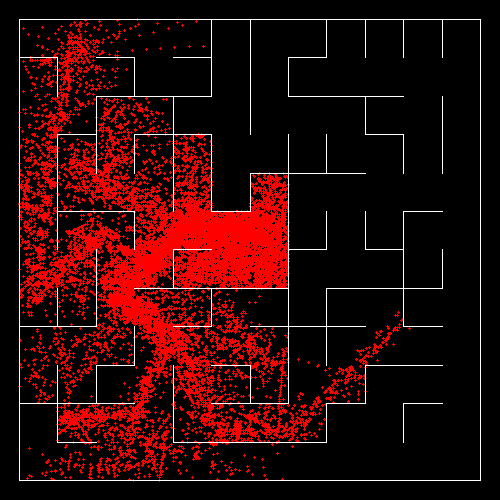

In [3]:
from IPython.display import display
from PIL import Image

env = lge.model.env
img = env.render("rgb_array")
img = Image.fromarray(img)
display(img)

Now, we will compute the coverage. Fist, we need to get all the observations.

In [4]:
import numpy as np

observations = lge.replay_buffer.next_observations["observation"][:num_timesteps]

# `observations` has the shape (num_timesteps x num_envs x obs_shape) with num_env = 1.
# So we squeeze `observations` so that it has a shape of (num_timesteps x obs_shape).
observations = np.squeeze(observations)

Then, we compute an approximation of the space coverage by dividing the state space into bin of size 1 x 1.

In [5]:
bins = np.floor(observations)  # Divide the space into 1 x 1 bins.
unique, bin_uids = np.unique(bins, axis=0, return_inverse=True)  # Each bin has its own UID

explored_uid_so_far = []
coverage = np.zeros(num_timesteps)
for t in range(num_timesteps):
    bin_uid = bin_uids[t]
    if not bin_uid in explored_uid_so_far:
        explored_uid_so_far.append(bin_uid)
    coverage[t] = len(explored_uid_so_far) / (24 * 24)  # there are 24 x 24 reachable bins

Now, we can plot the coverage through timesteps.

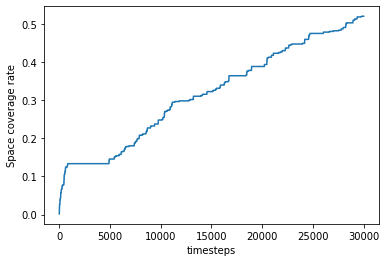

In [6]:
import matplotlib.pyplot as plt

plt.xlabel("timesteps")
plt.ylabel("Space coverage rate")
plt.plot(coverage)

Now we want to see what the latent space looks like. To do this, we will plot all the latent representations we encounter as scatter plots. The color of these points gives the probability that the corresponding observation is sampled as a goal.

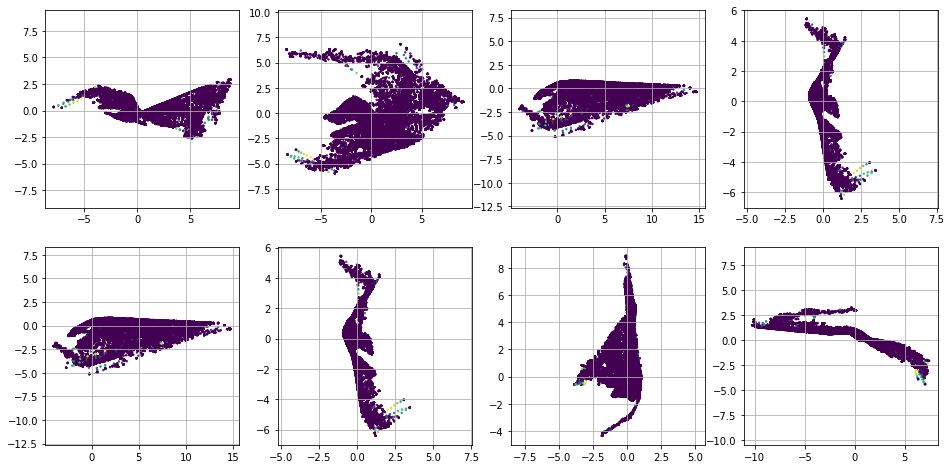

In [7]:
# Some borring lines to get the probability of each observation to be sampled as goal
lge.replay_buffer.recompute_embeddings()
embeddings = lge.replay_buffer.next_embeddings[:num_timesteps]
embeddings = np.squeeze(embeddings)
sorted_density = lge.replay_buffer.sorted_density[:num_timesteps]
_, index = np.unique(sorted_density, return_index=True)
p = lge.replay_buffer.p
prob = (1 - p) ** (np.arange(num_timesteps) - 1) * p
prob = prob[index]

# Get a color map to render this probability
cmap = plt.get_cmap()
color = cmap(prob / prob.max())

fig, axs = plt.subplots(2, 4)
fig.set_figheight(8)  # increase size, for readibility
fig.set_figwidth(16)

# Plot latent space
for row in range(2):
    for col in range(4):
        axs[row, col].grid()
        axs[row, col].axis("equal")
        latent_idx = 2 * (2 * row + col)
        axs[row, col].scatter(*embeddings[:, latent_idx : latent_idx + 2].T, c=color, s=2)